In [1]:
#Import packages
%autosave 0
import math
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
torch.manual_seed(1)
import random; random.seed(1)
torch.random.manual_seed(1)
import matplotlib.pyplot as mat
from sklearn.model_selection import StratifiedKFold, train_test_split

Autosave disabled


In [2]:
torch.cuda.is_available()

True

In [3]:
if torch.cuda.is_available():  
  device = torch.device("cuda")
else:  
  device = torch.device("cpu")

In [4]:
#Import data and read data
!gdown --id 1kITtYOXEMXCg-MGcnr_vv-itAW0KJukL

file=pd.read_csv("/content/SP500RM", sep=" ")
snp=file.RV
snp

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kITtYOXEMXCg-MGcnr_vv-itAW0KJukL
To: /content/SP500RM
100% 576k/576k [00:00<00:00, 142MB/s]


0       0.372097
1       0.558753
2       0.550684
3       1.969942
4       0.692383
          ...   
4091    0.180488
4092    0.446725
4093    0.257693
4094    0.348314
4095    0.540351
Name: RV, Length: 4096, dtype: float64

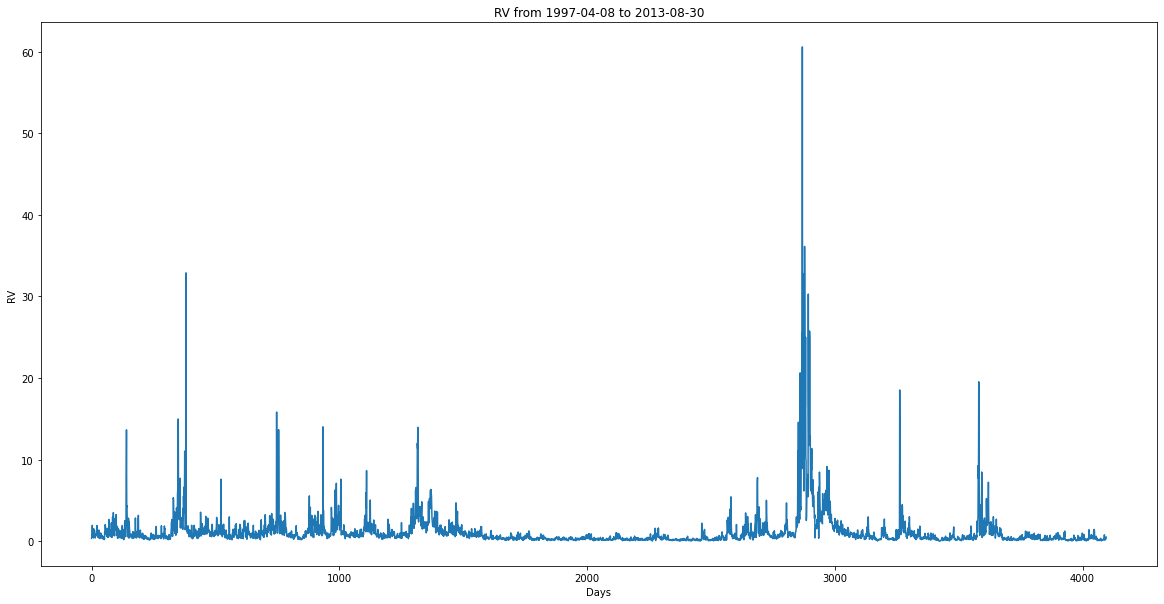

In [5]:
#Plotting RV values
mat.figure(figsize=(20,10))
mat.plot(snp)
mat.title("RV from 1997-04-08 to 2013-08-30")
mat.xlabel("Days")
mat.ylabel("RV")
mat.show()

In [6]:
# Train/test/validation splitting
train_rv, test_rv = train_test_split(snp,test_size=0.108,shuffle=False) #test size chose s.t. we get 222 obs for final test_rv to account for sequence length of 22

#Further splitting for validation set
val_rv, test_rv = train_test_split(test_rv,test_size=0.5,shuffle=False)

#Changing to numpy arrays
train_rv=np.array(train_rv)
val_rv=np.array(val_rv)
test_rv=np.array(test_rv)

In [7]:
#Function for creating train, validation and test data
def lag_windows(data,seq_length):
    x=[]; y=[]
    
    for i in range (len(data)-seq_length):
        x1=data[i:(seq_length+i)]
        y1=data[seq_length+i]
        x.append(x1)
        y.append(y1)
        
    return np.array(x), np.array(y)

In [8]:
# Creating test, validation and test data
seq_length=22

train_x, train_y = lag_windows(train_rv,seq_length)
val_x, val_y = lag_windows(val_rv,seq_length)
test_x, test_y = lag_windows(test_rv,seq_length)

In [9]:
#Note that we are using unbatched input here for TSA as opposed to the batched for SA tasks. Therefore, the definition of the shapes will be slightly different. See pytorch documentation.
#This NeuralNet only takes the last hidden state of the LSTM and sends it to the linear layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size_model, num_layers, seq_length, p_dropout):
        super(NeuralNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=p_dropout) #Arguments
        self.l1 = nn.Linear(hidden_size,1) # Only taking last output from LSTM. Use nn.Linear(hidden_size*sentence_length, 1) to make it fully connected, usually used for sentiment analysis

    # I = input_size, L = sentence_length, D = embed_dim, H = hidden_size
    def forward(self, x):
        h0 = torch.zeros(num_layers,batch_size_model, hidden_size).to(device) #redundant, can be removed and will still work as it is same values as default
        c0 = torch.zeros(num_layers,batch_size_model, hidden_size).to(device) #redundant, can be removed and will still work as it is same values as default
        out = x.view(batch_size_model,seq_length,-1) #reshaping to a Input (B, L) outputs (B, L, I) tensor
        out, _ = self.lstm1(out,(h0,c0)) #Inputs (B, L, I) outputs (B, L, H)
        out =  out[:,-1,:] #Only taking last output from LSTM for each batch. Inputs (B, L, H) outputs (B, H)
        out = self.l1(out) #Inputs (B, H) outputs (B, 1)
        return out

In [10]:
# Initialize a model. Parameters don't matter at this stage, we are just initializing so we can load the dependent functions below.
seq_length=seq_length
batch_size_model=600
input_size=1 #No. of features
hidden_size=128
num_layers=2
p_dropout=0

model = NeuralNet(input_size, hidden_size, batch_size_model, num_layers, seq_length, p_dropout)
model = model.to(device)
model

NeuralNet(
  (lstm1): LSTM(1, 128, num_layers=2, batch_first=True)
  (l1): Linear(in_features=128, out_features=1, bias=True)
)

In [11]:
# Define an optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define a loss function, which computes to binary cross entropy loss
def loss_function(batch_preds, batch_true):   
    # Calculate the loss for the whole batch
    mseloss = nn.MSELoss(reduction='mean') #Using mean here accounts for batch_size
    loss = mseloss(batch_preds, batch_true.float())

    # Rescale the loss. Already accounted for in BCEloss
    #loss = loss / batch_size

    return loss

In [12]:
# Function that will be called in every epoch
def train_epoch(loss_function, optimizer, model, train_loader):
  
  model.train()
  # Keep track of the total loss for the batch
  total_loss_train = 0
  total_loss_test = 0
  for batch_inputs, batch_true in train_loader:
    # Clear the gradients
    optimizer.zero_grad()
    # Run a forward pass
    global batch_size_model
    batch_size_model=batch_size
    outputs = model.forward(batch_inputs)
    # Compute the batch loss
    loss = loss_function(outputs, batch_true) 
    # Calculate the gradients
    loss.backward()
    #Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)
    # Update the parameteres
    optimizer.step()
    total_loss_train += loss.item()/len(train_loader) #one full epoch loss. Divide by epoch size to get average training loss

  model.eval()  
  for test_inputs, test_true in test_loader:
    # Run a forward pass
    batch_size_model=1
    outputs = model.forward(test_inputs)
    # Compute the batch loss
    loss = loss_function(outputs, test_true)
    total_loss_test += loss.item()/len(test_loader)


  return total_loss_train, total_loss_test


# Function containing our main training loop
def train(loss_function, optimizer, model, train_loader, num_epochs):
  global history
  history=[]
  # Iterate through each epoch and call our train_epoch function
  for epoch in range(num_epochs):
    epoch_loss = train_epoch(loss_function, optimizer, model, train_loader)
    if epoch % 1 == 0: print('Epoch:',epoch+1,'Average Training Loss:', epoch_loss[0], 'Validation Loss:', epoch_loss[1])
    history.append(epoch_loss)
    
        

# This part is for the tuning of hyperparameters with the validation set

In [88]:
#Hyperparameters
#Don't forget to change seq length as an input also. Currently using 22
random.seed(1)
torch.random.manual_seed(1)

batch_size=1
hidden_size=512
num_epochs = 150
learning_rate=0.0005
p_dropout=0.1

In [89]:
%%time
#Tuning on Validation set

#Create Tensor training Dataset
train_dataset=TensorDataset(torch.from_numpy(train_x).float().to(device), torch.from_numpy(train_y).float().to(device))
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=False,drop_last=True)

#Create Tensor validation dataset
test_dataset=TensorDataset(torch.from_numpy(val_x).float().to(device), torch.from_numpy(val_y).float().to(device))
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False,drop_last=False)

#Initializing model
model = NeuralNet(input_size, hidden_size, batch_size_model, num_layers, seq_length, p_dropout)
model = model.to(device)

# Define an optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Train model for validation
train(loss_function, optimizer, model, train_loader, num_epochs=num_epochs)
    

Epoch: 1 Average Training Loss: 6.096093714813381 Validation Loss: 0.08032772691594303
Epoch: 2 Average Training Loss: 5.688179782881989 Validation Loss: 0.07975307565247382
Epoch: 3 Average Training Loss: 5.484126090294043 Validation Loss: 0.07214522603807101
Epoch: 4 Average Training Loss: 5.226051373076328 Validation Loss: 0.06246563415196157
Epoch: 5 Average Training Loss: 4.911206559271819 Validation Loss: 0.052628587910365336
Epoch: 6 Average Training Loss: 4.581949450036654 Validation Loss: 0.04484288920003538
Epoch: 7 Average Training Loss: 4.2774359878603345 Validation Loss: 0.04059735200608477
Epoch: 8 Average Training Loss: 4.0627244843875046 Validation Loss: 0.03933266360874576
Epoch: 9 Average Training Loss: 3.925521113129211 Validation Loss: 0.03921494052620935
Epoch: 10 Average Training Loss: 3.8429676995981246 Validation Loss: 0.03933094665367164
Epoch: 11 Average Training Loss: 3.7873596444876845 Validation Loss: 0.039432286679284737
Epoch: 12 Average Training Loss: 3.

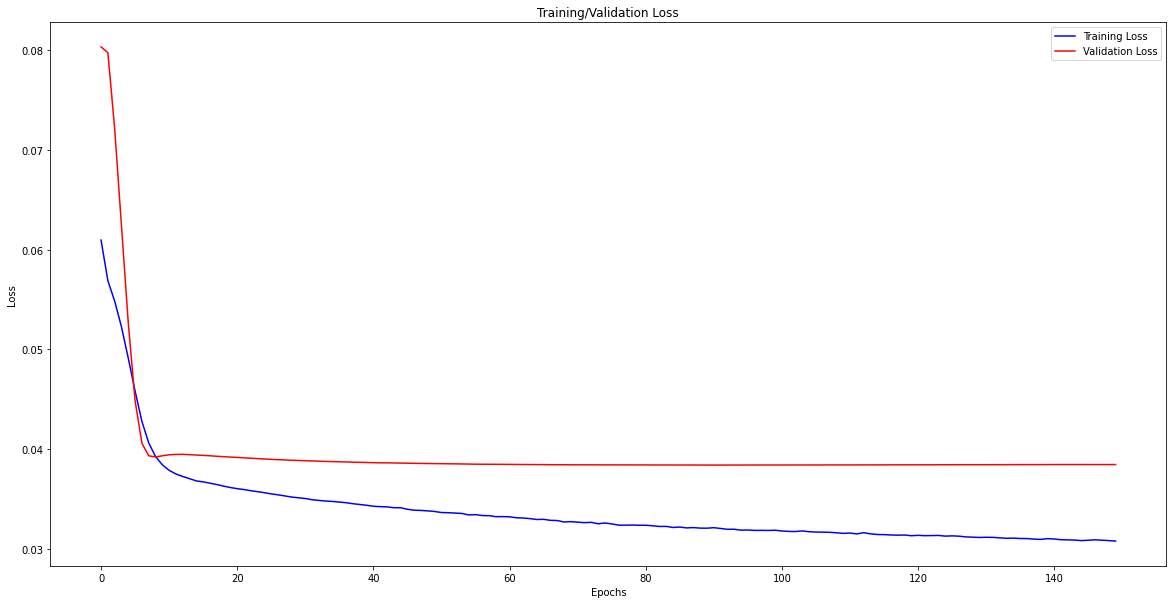

In [90]:
  #Plotting Losses
  history=np.array(history)
  mat.figure(figsize=(20,10))
  mat.plot(history[:,0]/100, 'b-', label='Training Loss')
  mat.plot(history[:,1], 'r-', label='Validation Loss')
  mat.title("Training/Validation Loss")
  mat.xlabel("Epochs")
  mat.ylabel("Loss")
  mat.legend(loc="upper right") 
  mat.show()

In [91]:
#Create Tensor dataset to see how model works on training data
train_dataset=TensorDataset(torch.from_numpy(train_x).float().to(device), torch.from_numpy(train_y).float().to(device))
train_fit_loader=DataLoader(train_dataset,batch_size=1,shuffle=False,drop_last=True)

train_fit=[]
for train_input, train_labels in train_fit_loader:
  batch_size_model=1
  outputs = model.forward(train_input).detach().tolist()[0][0]
  train_fit.append(outputs)

train_fit=pd.DataFrame(zip(list(range(22,3653)),train_fit),columns=["Index","RV_hat"])
train_fit=train_fit.set_index('Index')
train_fit

,RV_hat
Index,
22,0.934581
23,1.162909
24,1.300177
25,1.091143
26,0.932851
...,...
3648,1.302359
3649,1.036836
3650,0.895558


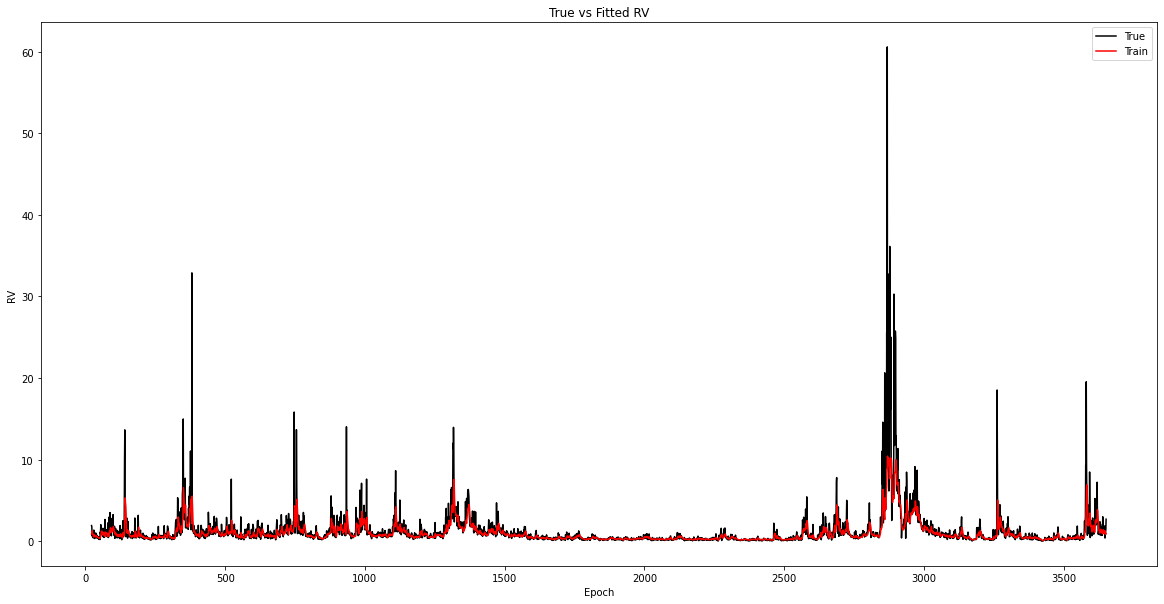

In [92]:
#Plotting fitted values
mat.figure(figsize=(20,10))
mat.plot(snp[22:3653], 'k-', label='True')
mat.plot(train_fit, 'r-', label='Train')
mat.title("True vs Fitted RV")
mat.xlabel("Epoch")
mat.ylabel("RV")
mat.legend(loc="upper right") 
mat.show()

In [93]:
#Fitted MSE & QLIKE
X=np.array(snp[22:3653]); X_hat=np.array(train_fit.RV_hat)
MSE=np.mean(np.square(X-X_hat))
QLIKE = np.mean((X/X_hat)-np.log(X/X_hat)-1)
print("MSE:",MSE)
print("QLIKE:",QLIKE)

MSE: 3.258795243471113
QLIKE: 0.1537280335887911


In [94]:
#Predicted values
pred=[]
for test_input, test_labels in test_loader:
  batch_size_model=1
  outputs = model.forward(test_input).detach().tolist()[0][0]
  pred.append(outputs)

pred=pd.DataFrame(zip(list(range(3675,3874)),pred),columns=["Index","RV_hat"])
pred=pred.set_index('Index')
pred

,RV_hat
Index,
3675,0.685552
3676,0.706846
3677,0.594254
3678,0.463536
3679,0.370981
...,...
3869,0.333391
3870,0.444834
3871,0.463826


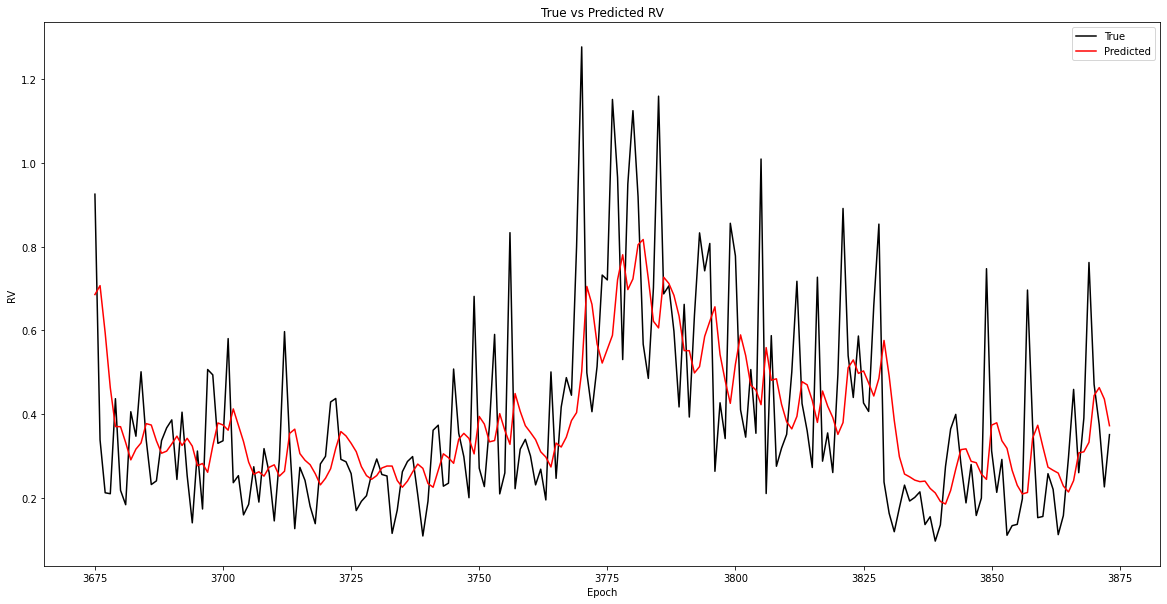

In [95]:
#Plotting predicted values
mat.figure(figsize=(20,10))
mat.plot(snp[3675:3874], 'k-', label='True')
mat.plot(pred, 'r-', label='Predicted')
mat.title("True vs Predicted RV")
mat.xlabel("Epoch")
mat.ylabel("RV")
mat.legend(loc="upper right") 
mat.show()
        

In [96]:
#Prediction MSE & QLIKE
X=np.array(snp[3675:3874]); X_hat=np.array(pred.RV_hat)
MSE=np.mean(np.square(X-X_hat))
QLIKE = np.mean((X/X_hat)-np.log(X/X_hat)-1)
print("MSE:",MSE)
print("QLIKE:",QLIKE)

MSE: 0.03845401335183014
QLIKE: 0.11141818503317596


#This part is for the training of the final model

In [97]:
#Creating new training data (including validation set from before). Test data remains untouched from the start.
train_rv=np.concatenate((train_rv,val_rv),axis=None)

train_x, train_y = lag_windows(train_rv,seq_length)

In [98]:
#Hyperparameters
#Don't forget to change seq length as an input also. Currently using 22
random.seed(1)
torch.random.manual_seed(1)

batch_size=1
hidden_size=512
num_epochs = 100
learning_rate=0.0005
p_dropout=0.1

In [99]:
#Initializing model
model = NeuralNet(input_size, hidden_size, batch_size_model, num_layers, seq_length, p_dropout)
model = model.to(device)

In [ ]:
#Loading model (Must run all code before # Define an optimizer)
model.load_state_dict(torch.load('/content/RV_LSTM_00',map_location=torch.device('cpu')))
model.eval()

NeuralNet(
  (lstm1): LSTM(1, 1024, num_layers=2, batch_first=True)
  (l1): Linear(in_features=1024, out_features=1, bias=True)
)

In [100]:
%%time
#Tuning on Validation set

#Create Tensor training Dataset
train_dataset=TensorDataset(torch.from_numpy(train_x).float().to(device), torch.from_numpy(train_y).float().to(device))
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=False,drop_last=True)

#Create Tensor test dataset
test_dataset=TensorDataset(torch.from_numpy(test_x).float().to(device), torch.from_numpy(test_y).float().to(device))
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False,drop_last=False)

#Initializing model
model = NeuralNet(input_size, hidden_size, batch_size_model, num_layers, seq_length, p_dropout)
model = model.to(device)

# Define an optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Train model for validation
train(loss_function, optimizer, model, train_loader, num_epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 Average Training Loss: 5.768150705709659 Validation Loss: 0.09628166605503792
Epoch: 2 Average Training Loss: 5.354742528501548 Validation Loss: 0.09323932355103348
Epoch: 3 Average Training Loss: 5.134378987012834 Validation Loss: 0.08476017909001711
Epoch: 4 Average Training Loss: 4.849875649982681 Validation Loss: 0.07480240645983492
Epoch: 5 Average Training Loss: 4.5249664524416 Validation Loss: 0.06585138221982786
Epoch: 6 Average Training Loss: 4.196132378414859 Validation Loss: 0.06036604352270902
Epoch: 7 Average Training Loss: 3.936655343348446 Validation Loss: 0.058408544300579
Epoch: 8 Average Training Loss: 3.7765466629094426 Validation Loss: 0.058182446524847345
Epoch: 9 Average Training Loss: 3.6737178236904335 Validation Loss: 0.05833524698091323
Epoch: 10 Average Training Loss: 3.6085029527772354 Validation Loss: 0.058454382138552745
Epoch: 11 Average Training Loss: 3.5679570292455227 Validation Loss: 0.058509737571428105
Epoch: 12 Average Training Loss: 3.539

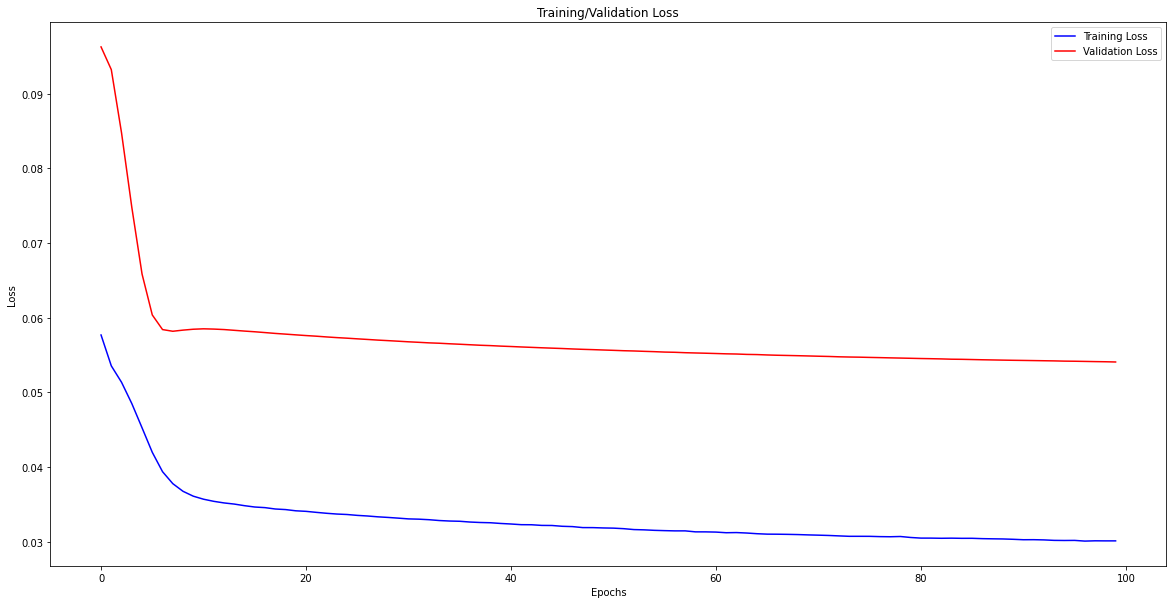

In [101]:
  #Plotting Losses
  history=np.array(history)
  mat.figure(figsize=(20,10))
  mat.plot(history[:,0]/100, 'b-', label='Training Loss')
  mat.plot(history[:,1], 'r-', label='Validation Loss')
  mat.title("Training/Validation Loss")
  mat.xlabel("Epochs")
  mat.ylabel("Loss")
  mat.legend(loc="upper right") 
  mat.show()

In [102]:
#Create Tensor dataset to see how model works on training data
train_dataset=TensorDataset(torch.from_numpy(train_x).float().to(device), torch.from_numpy(train_y).float().to(device))
train_fit_loader=DataLoader(train_dataset,batch_size=1,shuffle=False,drop_last=True)

train_fit=[]
for train_input, train_labels in train_fit_loader:
  batch_size_model=1
  outputs = model.forward(train_input).detach().tolist()[0][0]
  train_fit.append(outputs)

train_fit=pd.DataFrame(zip(list(range(22,3874)),train_fit),columns=["Index","RV_hat"])
train_fit=train_fit.set_index('Index')
train_fit

,RV_hat
Index,
22,0.905412
23,1.107591
24,1.247645
25,1.096077
26,0.955851
...,...
3869,0.320834
3870,0.417660
3871,0.444695


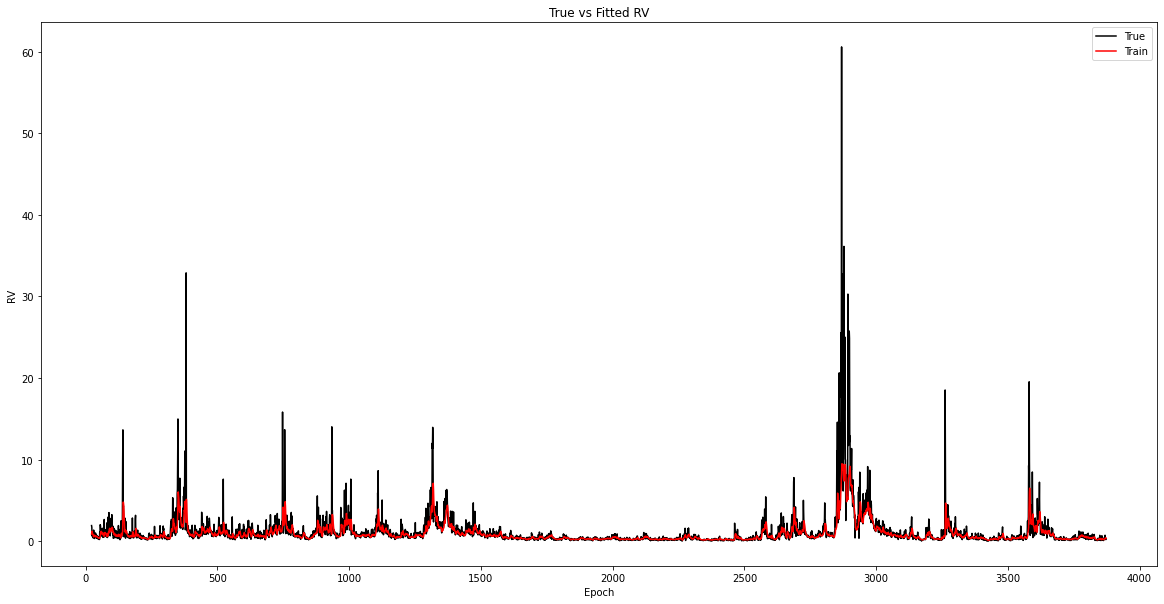

In [103]:
#Plotting fitted values
mat.figure(figsize=(20,10))
mat.plot(snp[22:3874], 'k-', label='True')
mat.plot(train_fit, 'r-', label='Train')
mat.title("True vs Fitted RV")
mat.xlabel("Epoch")
mat.ylabel("RV")
mat.legend(loc="upper right") 
mat.show()

In [104]:
#Fitted MSE & QLIKE
X=np.array(snp[22:3874]); X_hat=np.array(train_fit.RV_hat)
MSE=np.mean(np.square(X-X_hat))
QLIKE = np.mean((X/X_hat)-np.log(X/X_hat)-1)
print("MSE:",MSE)
print("QLIKE:",QLIKE)

MSE: 3.17175195275409
QLIKE: 0.15537463093238604


In [105]:
#Create Tensor test dataset
test_dataset=TensorDataset(torch.from_numpy(test_x).float().to(device), torch.from_numpy(test_y).float().to(device))
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False,drop_last=False)

#Predicted values
pred=[]
for test_input, test_labels in test_loader:
  batch_size_model=1
  outputs = model.forward(test_input).detach().tolist()[0][0]
  pred.append(outputs)

pred=pd.DataFrame(zip(list(range(3896,4096)),pred),columns=["Index","RV_hat"])
pred=pred.set_index('Index')
pred

,RV_hat
Index,
3896,0.584760
3897,0.673785
3898,0.601297
3899,0.564787
3900,0.601723
...,...
4091,0.324990
4092,0.284941
4093,0.311038


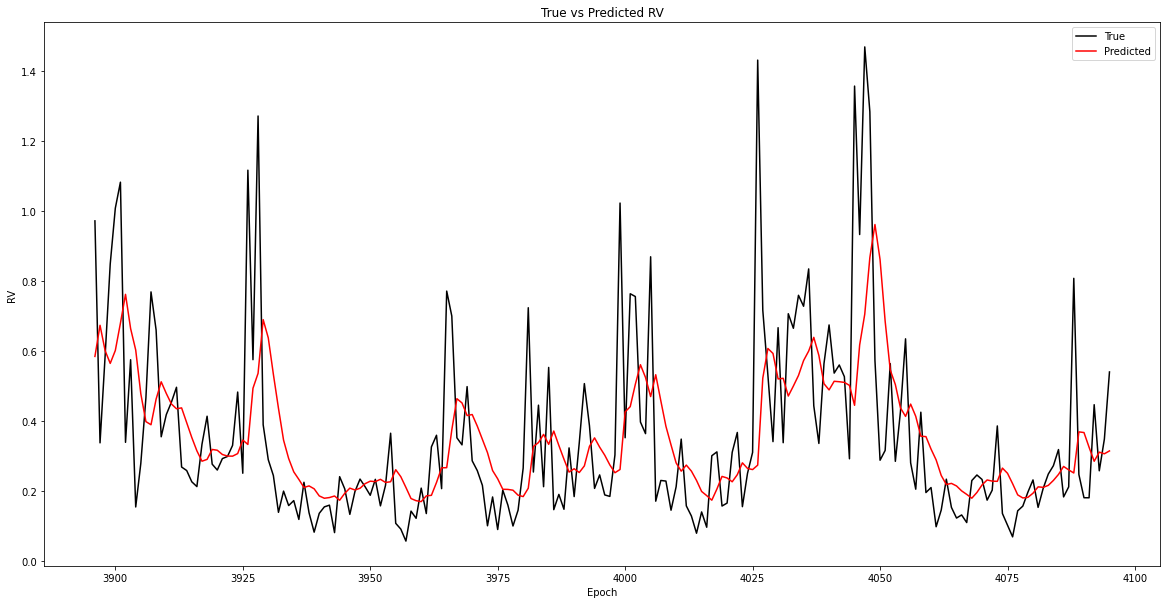

In [106]:
#Plotting predicted values
mat.figure(figsize=(20,10))
mat.plot(snp[3896:4096], 'k-', label='True')
mat.plot(pred, 'r-', label='Predicted')
mat.title("True vs Predicted RV")
mat.xlabel("Epoch")
mat.ylabel("RV")
mat.legend(loc="upper right") 
mat.show()

In [107]:
#Prediction MSE & QLIKE
X=np.array(snp[3896:4096]); X_hat=np.array(pred.RV_hat)
MSE=np.mean(np.square(X-X_hat))
QLIKE = np.mean((X/X_hat)-np.log(X/X_hat)-1)
print("MSE:",MSE)
print("QLIKE:",QLIKE)

MSE: 0.05406578033341099
QLIKE: 0.15141138708700821


In [109]:
#Saving model
torch.save(model.state_dict(), '/content/RV_LSTM_02')

In [111]:
#Saving results
df=pd.DataFrame(pred)
df.to_csv('/content/LSTM_RV_hat_02')